In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from keras.layers import Dropout,Conv1D, MaxPooling1D, Flatten,TimeDistributed,Bidirectional
import math
import datetime as dt
from datetime import datetime    
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError


def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

def reshape_data(df):
    X = []
    Y = []
    window_size=100
    for i in range(1 , len(df) - window_size -1 , 1):
        first = df.iloc[i,4]
        temp = []
        temp2 = []
        for j in range(window_size):
            temp.append((df.iloc[i + j, 4] - first) / first)
        temp2.append((df.iloc[i + window_size, 4] - first) / first)
        X.append(np.array(temp).reshape(100, 1))
        Y.append(np.array(temp2).reshape(1, 1))
    return X,Y

def get_train_and_test_values(df):
    X,Y = reshape_data(df)
    train_X_values,test_X_values,train_Y_values,test_Y_values = [],[],[],[]
    
    num_splits = 5
    split_size = len(X) / num_splits
    
    X_splits = [X[int(i * split_size):int((i + 1) * split_size)] for i in range(num_splits)]
    Y_splits = [Y[int(i * split_size):int((i + 1) * split_size)] for i in range(num_splits)]
    
        
    for i in range(num_splits):
        x_train, x_test, y_train, y_test = train_test_split(X_splits[i], Y_splits[i], test_size=0.2, shuffle=True)
        train_X = np.array(x_train)
        test_X = np.array(x_test)
        train_Y = np.array(y_train)
        test_Y = np.array(y_test)
        
        train_X = train_X.reshape(train_X.shape[0],1,100,1)
        test_X = test_X.reshape(test_X.shape[0],1,100,1)
        
        train_X_values.append(train_X)
        test_X_values.append(test_X)
        train_Y_values.append(train_Y)
        test_Y_values.append(test_Y)

    return train_X_values,test_X_values,train_Y_values,test_Y_values

def create_model():
    model = tf.keras.Sequential()
    
    # Creating the Neural Network model here...
    # CNN layers
    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    
    # LSTM layers
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.5))
    
    #Final layers
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

    return model


def train_model(company_name,model,train_X_values,test_X_values,train_Y_values,test_Y_values):
    for i in range(len(train_X_values)):
        model.fit(train_X_values[i], train_Y_values[i], validation_data=(test_X_values[i],test_Y_values[i]), epochs=20,batch_size=40, verbose=1, shuffle =True)
        model.save("checkpoints/"+company_name+"/cnn-lstm-"+str(i+1)+".keras")
    return model

def get_test_X_and_test_Y_data(data2):
    data2.dropna(inplace=True)
    data2.reset_index(drop=True, inplace=True)
    df2 = data2.drop('Date', axis=1)
    
    X,Y = reshape_data(df2)
    
    test_X = np.array(X)
    test_Y = np.array(Y)
    
    test_X = test_X.reshape(test_X.shape[0],1,100,1)

    return test_X,test_Y

def evaluate_model(model,test_X,test_Y,data2,shift):
    # loss, mse, mae = model.evaluate(test_X, test_Y)
    # print("Mean Squared Error (MSE):", mse)
    # print("Mean Absolute Error (MAE):", mae)
    predicted = model.predict(test_X)
    test_label = test_Y.reshape(-1, 1)
    predicted = np.array(predicted[:, 0]).reshape(-1, 1)
    len_t = len(test_X)
    # print("Number of test samples:", len_t)
    print("calculations")

    for j in range(len_t):
        temp = data2.iloc[j+len_t*shift,3]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp
    
    # Calculate MAE
    mae_sum = 0
    for j in range(len_t):
        mae_sum += abs(test_label[j] - predicted[j])
    mae = mae_sum / len_t

    # Calculate RMSE
    mse_sum = 0
    for j in range(len_t):
        mse_sum += (test_label[j] - predicted[j]) ** 2
    rmse = np.sqrt(mse_sum / len_t)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    
    # plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    # plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
    # plt.title(' Stock Price Prediction')
    # plt.xlabel('Time')
    # plt.ylabel(' Stock Price')
    # plt.legend()
    # plt.show()

def train_model_for_stocks(company_name):
    file_name = "..\\..\\data\\processed\\"
    file_name += company_name+'.csv'
    data = import_data_from_csv(file_name)
    train_X_values,test_X_values,train_Y_values,test_Y_values = get_train_and_test_values(data)
    model = create_model()
    model = train_model(company_name,model,train_X_values,test_X_values,train_Y_values,test_Y_values)
    return model
    

def main():
    # train_model_for_stocks("AAPL")
    # train_model_for_stocks("GOOG")
    # train_model_for_stocks("MSFT")
    # train_model_for_stocks("NFLX")
    # train_model_for_stocks("NVDA")
    # train_model_for_stocks("TSLA")
    pass

if __name__ == "__main__":
    main()

In [7]:
def load_saved_model(file_path):
    """
    Loads a saved Keras model from file.
    """
    return load_model(file_path)

def load_models(company_name):
    """
    Loads saved models for a given company.
    """
    models = []
    for i in range(1, 6):  # Assuming you saved 5 models for each company
        model_path = f"checkpoints/{company_name}/cnn-lstm-{i}.keras"
        model = load_saved_model(model_path)
        models.append(model)
    return models

def test_loaded_models(company_name):
    """
    Tests the loaded models for a given company.
    """
    data = import_data_from_csv(f"../../data/processed/{company_name}.csv")
    print(company_name)
    # print(data)
    test_X, test_Y = get_test_X_and_test_Y_data(data)
    models = load_models(company_name)
    for i, model in enumerate(models):
        print(f"Model {i+1}:")
        start_idx = int(len(test_X) * i / 5)
        end_idx = int(len(test_X) * (i + 1) / 5)
        evaluate_model(model, test_X[start_idx:end_idx], test_Y[start_idx:end_idx],data,i)


def test_models_for_stocks():
    """
    Tests the saved models for multiple stocks.
    """
    companies = ["AAPL", "GOOG", "MSFT", "NFLX", "NVDA", "TSLA"]
    for company in companies:
        test_loaded_models(company)


test_models_for_stocks()

AAPL
Model 1:
20/20 [==============================] - 5s 13ms/step
calculations
Root Mean Squared Error (RMSE): [0.59522245]
Mean Absolute Error (MAE): [0.46739552]
Model 2:
20/20 [==============================] - 4s 11ms/step
calculations
Root Mean Squared Error (RMSE): [0.64289588]
Mean Absolute Error (MAE): [0.50343294]
Model 3:
20/20 [==============================] - 4s 11ms/step
calculations
Root Mean Squared Error (RMSE): [1.01221559]
Mean Absolute Error (MAE): [0.77625471]
Model 4:
20/20 [==============================] - 4s 10ms/step
calculations
Root Mean Squared Error (RMSE): [2.87133695]
Mean Absolute Error (MAE): [2.21688958]
Model 5:
20/20 [==============================] - 4s 10ms/step
calculations
Root Mean Squared Error (RMSE): [3.8128077]
Mean Absolute Error (MAE): [3.09301246]
GOOG
Model 1:
20/20 [==============================] - 5s 10ms/step
calculations
Root Mean Squared Error (RMSE): [0.45754899]
Mean Absolute Error (MAE): [0.34732571]
Model 2:
20/20 [=========

AAPL
Model 1:
20/20 [==============================] - 3s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 2s 6ms/step
Model 5:
20/20 [==============================] - 2s 6ms/step
3160


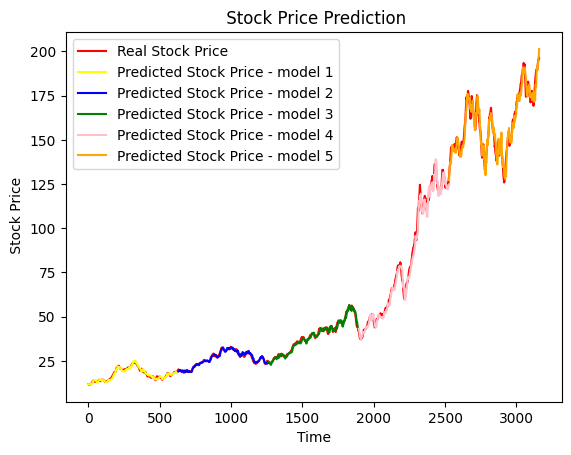

GOOG
Model 1:
20/20 [==============================] - 3s 7ms/step
Model 2:
20/20 [==============================] - 2s 7ms/step
Model 3:
20/20 [==============================] - 3s 7ms/step
Model 4:
20/20 [==============================] - 3s 7ms/step
Model 5:
20/20 [==============================] - 3s 8ms/step
3160


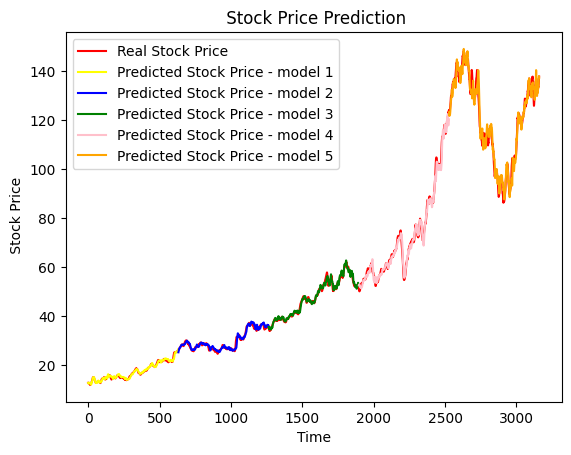

MSFT
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 7ms/step
Model 4:
20/20 [==============================] - 3s 7ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


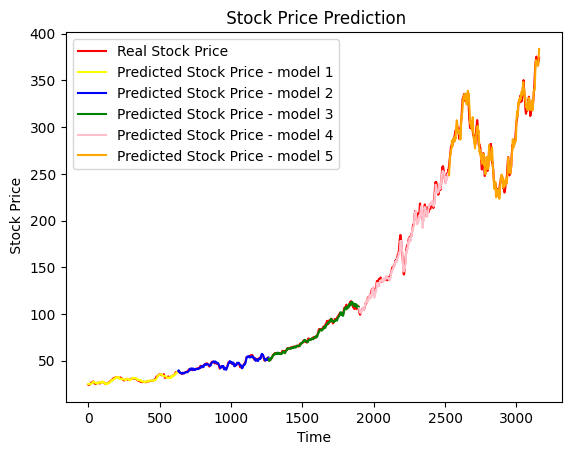

NFLX
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 2s 6ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


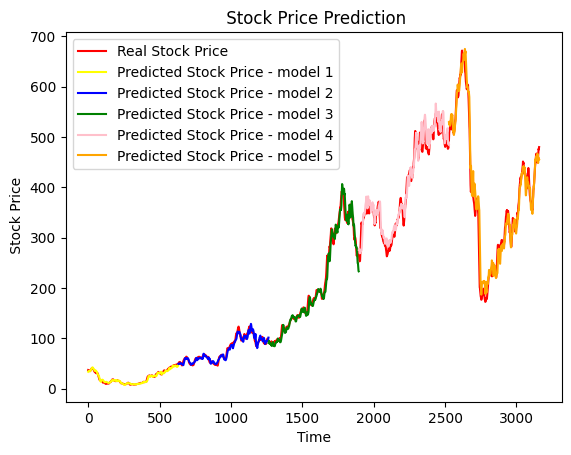

NVDA
Model 1:
20/20 [==============================] - 3s 7ms/step
Model 2:
20/20 [==============================] - 3s 7ms/step
Model 3:
20/20 [==============================] - 3s 7ms/step
Model 4:
20/20 [==============================] - 3s 10ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


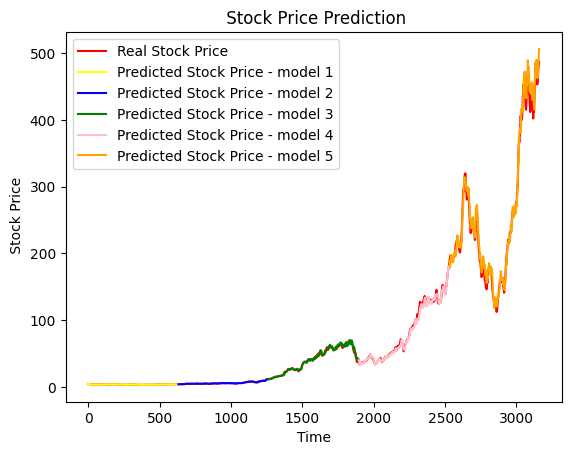

TSLA
Model 1:
20/20 [==============================] - 2s 6ms/step
Model 2:
20/20 [==============================] - 2s 6ms/step
Model 3:
20/20 [==============================] - 2s 6ms/step
Model 4:
20/20 [==============================] - 3s 8ms/step
Model 5:
20/20 [==============================] - 3s 7ms/step
3160


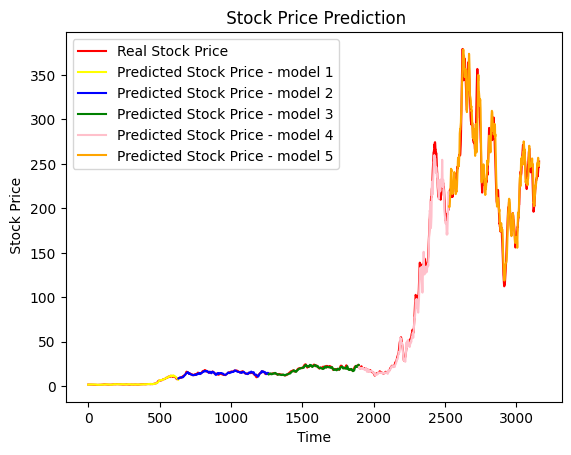

In [28]:

def draw_model(company_name):
    """
    Tests the loaded models for a given company.
    """
    data = import_data_from_csv(f"../../data/processed/{company_name}.csv")
    print(company_name)
    # print(data)
    test_X, test_Y = get_test_X_and_test_Y_data(data)
    
    models = load_models(company_name)
    predictions = []
    for i, model in enumerate(models):
        print(f"Model {i+1}:")
        start_idx = int(len(test_X) * i / 5)
        end_idx = int(len(test_X) * (i + 1) / 5)
        
        predicted = model.predict(test_X[start_idx:end_idx])
        predicted = np.array(predicted[:, 0]).reshape(-1, 1)
        predictions.append(predicted)

    test_label = test_Y.reshape(-1, 1)
    len_t = len(test_X)
    
    print(len_t)
    for j in range(len_t):
        temp = data.iloc[j,3]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
    len_tt = len_t//5
    for j in range(len_tt):
        temp = data.iloc[j,3]
        temp2 = data.iloc[j+len_tt,3]
        temp3 = data.iloc[j+len_tt*2,3]
        temp4 = data.iloc[j+len_tt*3,3]
        temp5 = data.iloc[j+len_tt*4,3]
        predictions[0][j - len_tt] = predictions[0][j - len_tt] * temp + temp
        predictions[1][j - len_tt] = predictions[1][j - len_tt] * temp2 + temp2
        predictions[2][j - len_tt] = predictions[2][j - len_tt] * temp3 + temp3
        predictions[3][j - len_tt] = predictions[3][j - len_tt] * temp4 + temp4
        predictions[4][j - len_tt] = predictions[4][j - len_tt] * temp5 + temp5
        
    shift_amount = len_t // 5  # Assuming 5 models

    plt.plot(test_label, color='red', label='Real Stock Price')

    # Plotting the predictions for each model, shifted accordingly
    colors= ["yellow","blue","green","pink","orange"]
    plt.plot(range(0 * shift_amount, 0 * shift_amount + len(predictions[0])), predictions[0], label=f'Predicted Stock Price - model {0 + 1}',color=colors[0])
    plt.plot(range(1 * shift_amount, 1 * shift_amount + len(predictions[1])), predictions[1], label=f'Predicted Stock Price - model {1 + 1}',color=colors[1])
    plt.plot(range(2 * shift_amount, 2 * shift_amount + len(predictions[2])), predictions[2], label=f'Predicted Stock Price - model {2 + 1}',color=colors[2])
    plt.plot(range(3 * shift_amount, 3 * shift_amount + len(predictions[3])), predictions[3], label=f'Predicted Stock Price - model {3 + 1}',color=colors[3])
    plt.plot(range(4 * shift_amount, 4 * shift_amount + len(predictions[4])), predictions[4], label=f'Predicted Stock Price - model {4 + 1}',color=colors[4])

    plt.title(' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.legend()
    plt.show()

companies = ["AAPL", "GOOG", "MSFT", "NFLX", "NVDA", "TSLA"]
for company in companies:
    draw_model(company)
